https://www.hfbrasil.org.br/br/estatistica/batata.aspx

https://cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx


In [2]:
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import batelada as bt


## Pré-processamento dos dados

In [3]:
df_batata = pd.read_excel("20221001214857-precos-medios-batata.xlsx")
df_batata = pl.DataFrame(df_batata)
date_batata = df_batata.select(
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=pl.col("Dia")).alias("Data")
)
df_batata = df_batata.with_column(date_batata.to_series())


In [4]:
df_batata.groupby(["Produto", "Unidade"]).agg(
    [
        pl.count(),
        pl.col("Data").min().alias("Inicio"),
        pl.col("Data").max().alias("Fim"),
        pl.col("Preço").mean().alias("Preço médio"),
        pl.col("Preço").std().alias("Preço desvio"),
        pl.col("Preço").min().alias("Preço menor"),
        pl.col("Preço").max().alias("Preço maior"),
    ]
).sort("count", reverse=True)


Produto,Unidade,count,Inicio,Fim,Preço médio,Preço desvio,Preço menor,Preço maior
str,str,u32,date,date,f64,f64,f64,f64
"""Padrão agata especial - beneficiador""","""saco 50 kg""",1101,2002-12-03,2021-12-30,63.197448,38.123117,9.0,230.0
"""Padrão agata primeira - beneficiador""","""saco 50 kg""",987,2002-12-03,2021-12-28,30.612067,20.963619,5.0,130.0
"""Padrão agata especial - produtor""","""saco 50 kg""",694,2002-12-03,2018-12-21,45.899957,32.197191,5.0,210.0
"""Monalisa especial - beneficiador""","""saco 50 kg""",129,2000-12-13,2006-01-05,31.978682,10.806773,13.5,77.0
"""Monalisa primeira - beneficiador""","""saco 50 kg""",125,2000-12-13,2006-01-05,14.5132,5.466655,3.0,30.0
"""Monalisa diversa - beneficiador""","""saco 50 kg""",119,2000-12-13,2006-01-05,14.655462,5.564243,3.0,30.0
"""Monalisa especial - produtor""","""saco 50 kg""",72,2001-01-03,2006-01-05,28.902778,11.229987,9.0,70.0
"""Padrão agata especial - beneficiador""","""saco 25 kg""",53,2022-01-03,2022-08-02,40.253019,12.3876,15.0,60.0
"""Padrão agata primeira - beneficiador""","""saco 25 kg""",34,2022-01-03,2022-08-02,25.911765,7.015643,10.0,35.0


In [5]:
df_agata = df_batata.filter(
    (pl.col("Produto") == "Padrão agata primeira - beneficiador")
    & (pl.col("Unidade") == "saco 50 kg")
    & (pl.col('Data').is_between(pl.datetime(2008, 1, 1), pl.datetime(2020, 12, 31)))
).select(["Data", "Preço", "Ano", "Mês"])


df_agata = df_agata.groupby(['Ano', 'Mês']).agg(
    [
        pl.col("Preço").mean().alias("Preço médio"),
        pl.col("Preço").std().alias("Preço desvio"),
        pl.col("Preço").min().alias("Preço menor"),
        pl.col("Preço").max().alias("Preço maior")
    ]
).select(
    [pl.all(),
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=1).alias("Data")]
).sort('Data')

df_agata = df_agata.upsample("Data", "1mo").interpolate().fill_null("forward")


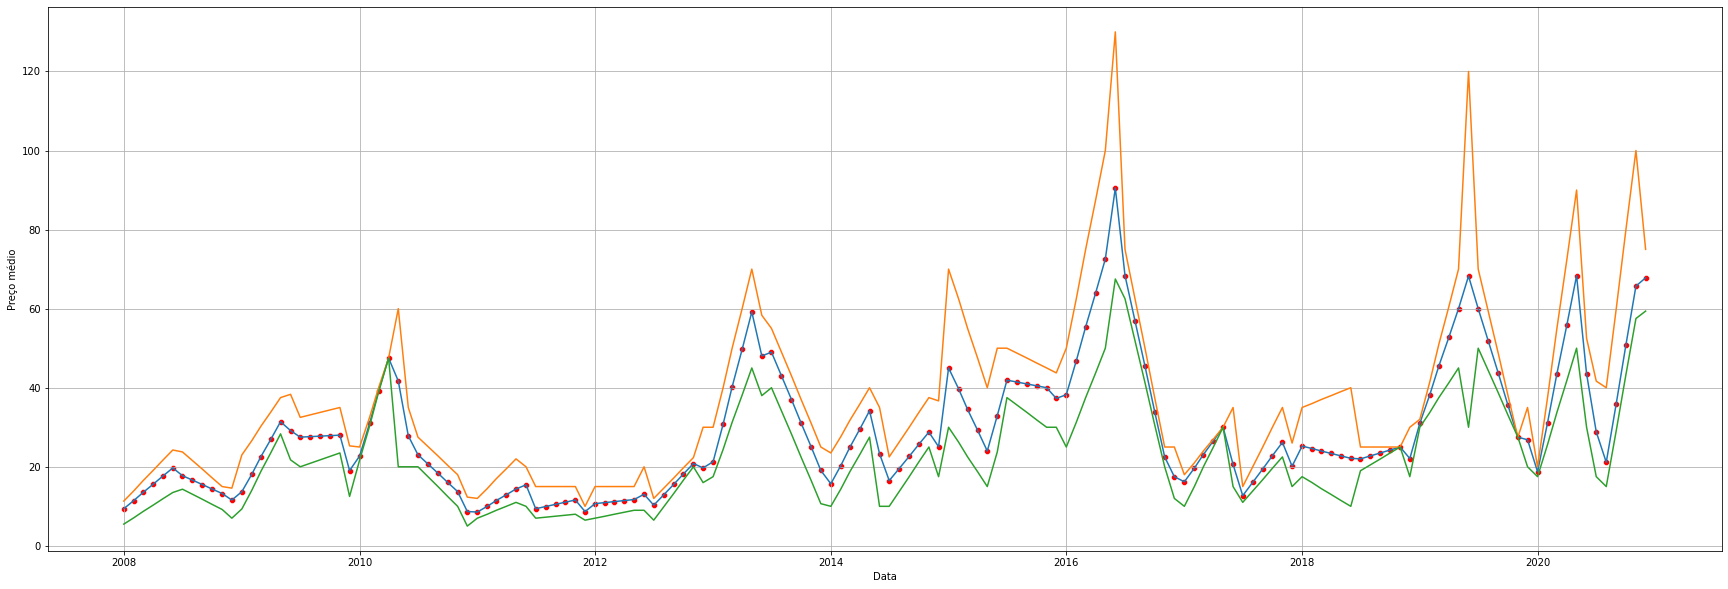

In [6]:
plt.figure(figsize = (30,10))
sns.lineplot(data=df_agata.to_pandas(), x='Data', y='Preço médio')
sns.lineplot(data=df_agata.to_pandas(), x='Data', y='Preço maior')
sns.lineplot(data=df_agata.to_pandas(), x='Data', y='Preço menor')
sns.scatterplot(data=df_agata.to_pandas(), x='Data', y='Preço médio', color='red')
plt.grid()
plt.show()
plt.close()

## Modelo ARX

In [7]:
# Importa um arquivo com os dados de saída
data = df_agata.select(['Mês', 'Preço médio']).to_numpy()


In [8]:
print('Método dos mínimos quadrados em batelada')
u = data[:,0] # Como os dados são sequênciais, é gerado uma sequência de números
y = data[:,1] # Salva os dados de saídas

u = u/u.std()
y = y/y.std()

print(f'Número de pontos: {u.size}')

Método dos mínimos quadrados em batelada
Número de pontos: 156


MSE 1: 0.15
MSE n: 2.02


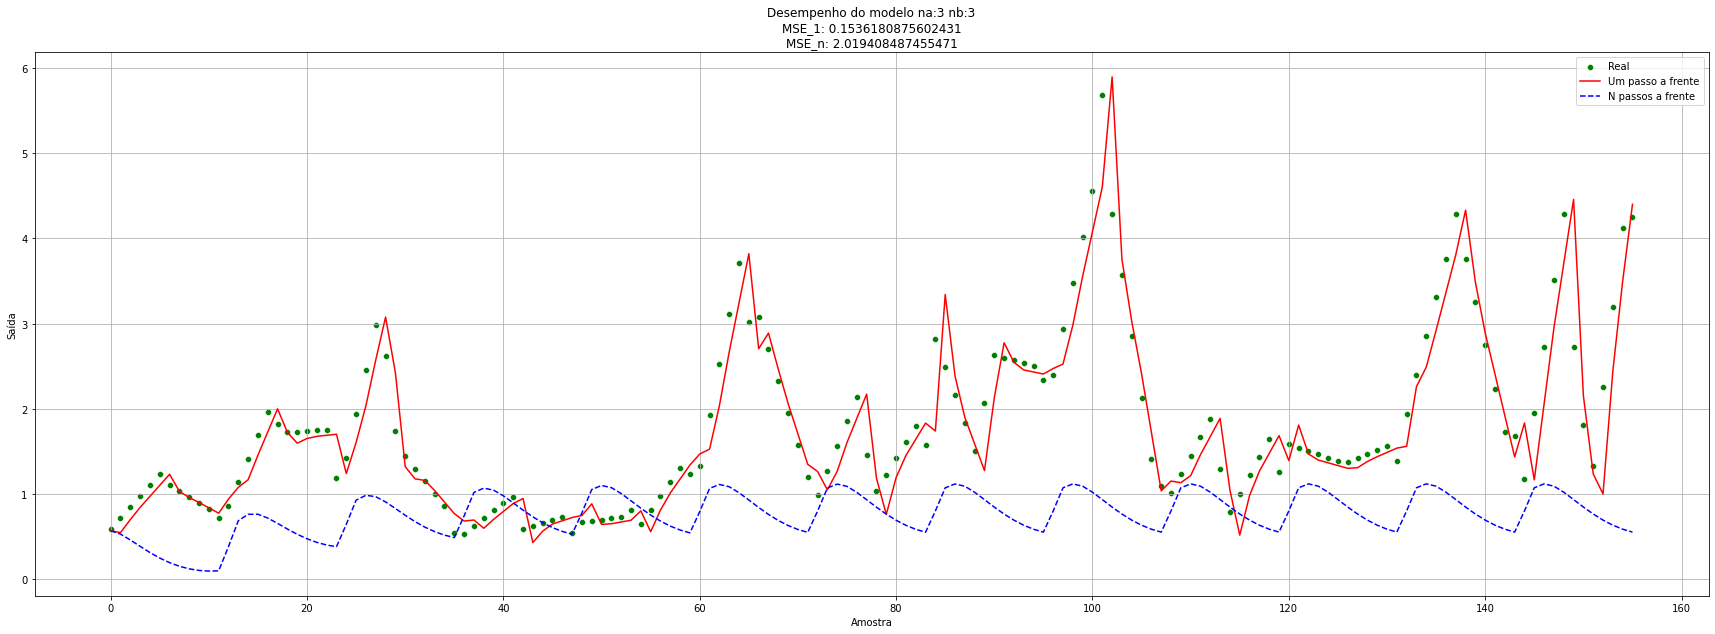

In [9]:
na, nb = 3, 3
delay = 0
yest_1, yest_n, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
MSE_n = np.sum((y-yest_n)**2)/(npts-deep)

print(f'MSE 1: {MSE_1:0.2f}')
print(f'MSE n: {MSE_n:0.2f}')
t = np.arange(y.size)

# Plota a figura
plt.figure(figsize = (30,10))
sns.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
#sns.barplot(x=t,y=np.abs(y-yest_1),color='purple')
sns.lineplot(x=t,y=yest_1,color='red',linestyle='-',label='Um passo a frente')
sns.lineplot(x=t,y=yest_n,color='blue',linestyle='--',label='N passos a frente')
plt.title(f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
plt.legend(labels=["Real","Um passo a frente","N passos a frente"])
plt.xlabel('Amostra')
plt.ylabel('Saída')
plt.grid()
plt.show()
plt.close()



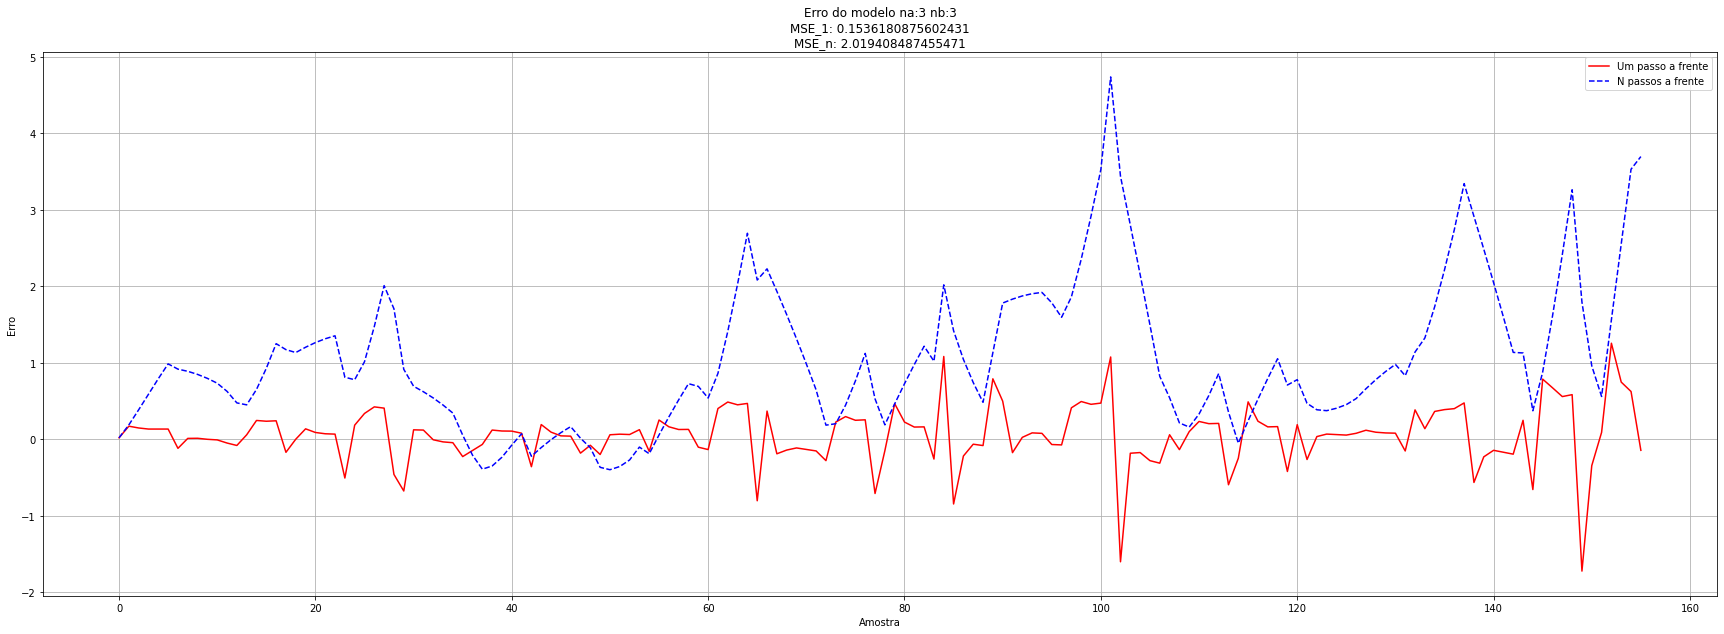

In [10]:
# Plota a figura
plt.figure(figsize = (30,10))
sns.lineplot(x=t,y=y-yest_1,color='red',linestyle='-',label='Um passo a frente')
sns.lineplot(x=t,y=y-yest_n,color='blue',linestyle='--',label='N passos a frente')
plt.title(f'Erro do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
plt.legend(labels=["Um passo a frente","N passos a frente"])
plt.xlabel('Amostra')
plt.ylabel('Erro')
plt.grid()
plt.show()
plt.close()


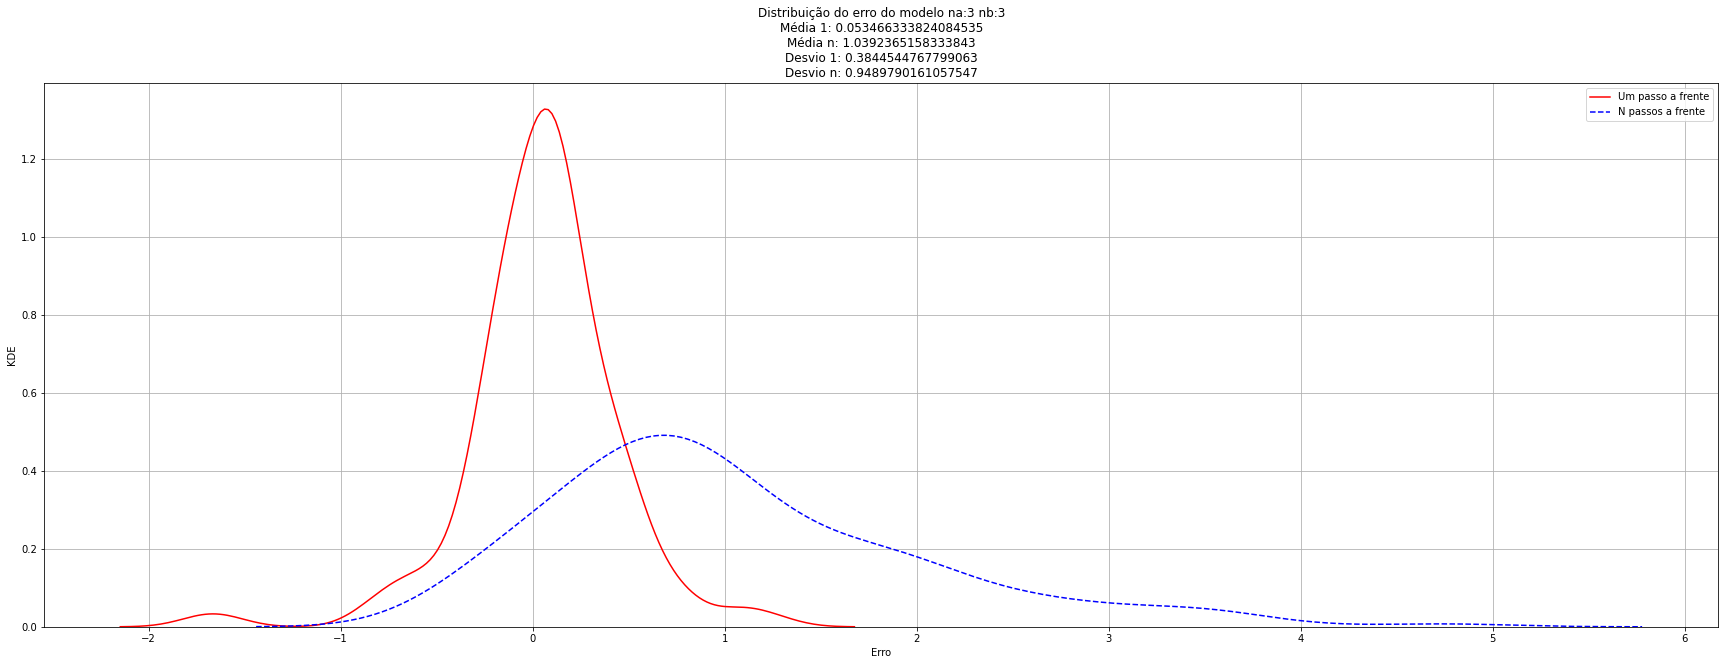

In [11]:
# Plota a figura
plt.figure(figsize = (30,10))
sns.kdeplot(x=y-yest_1,color='red',linestyle='-',label='Um passo a frente')
sns.kdeplot(x=y-yest_n,color='blue',linestyle='--',label='N passos a frente')
plt.title(f'''Distribuição do erro do modelo na:{na} nb:{nb}
Média 1: {(y-yest_1).mean()}\nMédia n: {(y-yest_n).mean()}
Desvio 1: {(y-yest_1).std()}\nDesvio n: {(y-yest_n).std()}''')
plt.legend(labels=["Um passo a frente","N passos a frente"])
plt.xlabel('Erro')
plt.ylabel('KDE')
plt.grid()
plt.show()
plt.close()


## Modelo ARMAX

In [12]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [13]:
armax = ARIMA(endog=y, order=(3, 3, 0), exog=u).fit()
resid = armax.resid

['x1', 'ar.L1', 'ar.L2', 'ar.L3', 'sigma2']
[-0.0265102  -0.85485742 -0.46291337 -0.16872965  0.32729816]


In [14]:
armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:                 ARIMA(3, 3, 0)   Log Likelihood                -132.038
Date:                Tue, 04 Oct 2022   AIC                            274.075
Time:                        17:49:17   BIC                            289.227
Sample:                             0   HQIC                           280.230
                                - 156                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0265      0.029     -0.927      0.354      -0.083       0.030
ar.L1         -0.8549      0.059    -14.415      0.000      -0.971      -0.739
ar.L2         -0.4629      0.075     -6.135      0.000      -0.611      -0.315
ar.L3         -0.1687      0.076     -2.223      0.026      -0.318      -0.020
sigma2         0.3273      0.022     15.201      0.000       0.285       0.369
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):               198.96
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               4.25   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

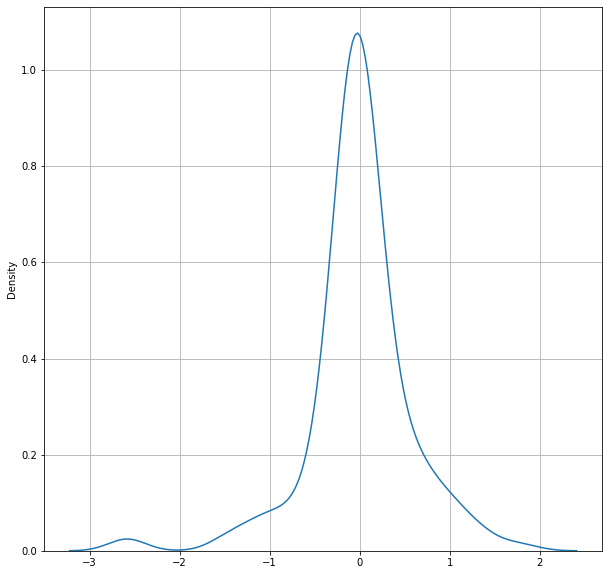

In [15]:
plt.figure(figsize=(10,10))
sns.kdeplot(resid)
plt.grid()
plt.show()
plt.close()

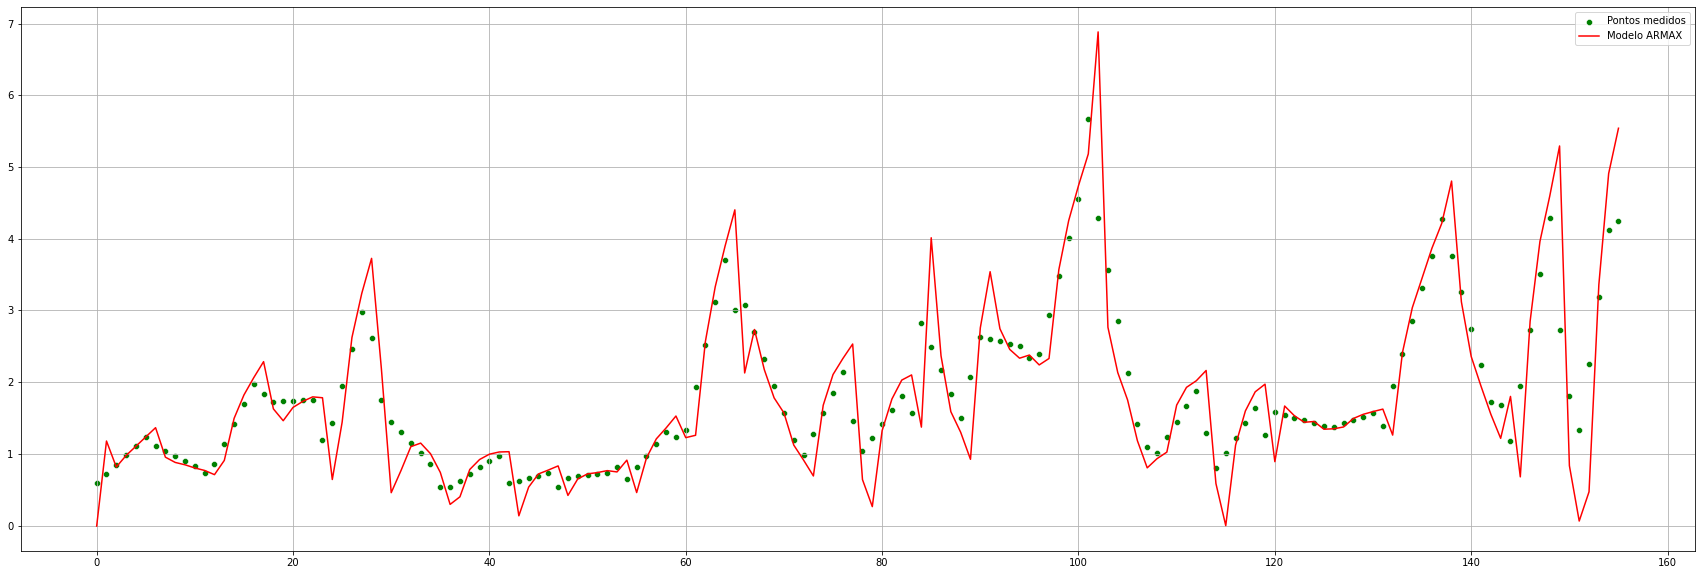

In [16]:
plt.figure(figsize = (30,10))
sns.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
res = armax.predict(exog=u)
sns.lineplot(x=t, y=res, color='red',label='Modelo ARMAX')
plt.grid()
plt.show()
plt.close()

# TOMAR NO CU MERDA DE LEITE DO CARALHO

In [76]:
df_leite = pd.read_excel("cepea-consulta-20221001213951-leite.xls")
df_leite = pl.DataFrame(df_leite)

In [88]:
columns = df_leite.columns[1:]
columns = [df_leite[c].str.replace(',','.').str.replace('-','NaN').apply(float).alias(c) for c in columns]

In [91]:
df_leite = df_leite.with_columns(columns)

In [99]:
df_leite = df_leite.with_column(('01/'+pl.col('Data')).str.strptime(pl.Date, fmt="%d/%m/%Y").alias('Data'))

In [100]:
df_leite

Data,Preço bruto mínimo,Preço bruto médio,Preço bruto máximo,Preço líquido mínimo,Preço líquido médio,Preço líquido máximo
date,f64,f64,f64,f64,f64,f64
2012-10-01,0.7588,0.8808,0.9383,0.6902,0.8097,0.8677
2012-11-01,0.768,0.8952,0.9561,0.6984,0.8221,0.8841
2012-12-01,0.7722,0.8934,0.9549,0.7046,0.8227,0.883
2013-01-01,0.759,0.8829,0.954,0.692,0.811,0.8838
2013-02-01,0.7756,0.8941,0.9618,0.7076,0.8219,0.8906
2013-03-01,0.795,0.9162,0.983,0.7255,0.8427,0.9072
2013-04-01,0.8335,0.9526,1.0206,0.7626,0.8766,0.9406
2013-05-01,0.8692,0.9854,1.0526,0.7972,0.9094,0.9728
2013-06-01,0.8944,1.0178,1.0882,0.8217,0.942,1.0084
